### Preface

Note that this is a contiuation of the previous NLP work. If any NLP treatments are changed, we need to update to make sure that the imported dataset reflects the latest NLP change, and is not affected by the latest change. If affected, then we need to re-label the dataset.

### Overview

Similar to the spam/ham classification exercise, the goal of this notebook is to use a supervised classification algorithm to build a model that is suitable for predicting whether attorneys need to act on a certain docket text. What was provided was the 600+ docket texts with labeled targets. Even though this is a small dataset to work with, this can be a good starting point. Steps to build a supervised classificaiton model:

1. Extract dataset from excel. Dataset contains cleaned texts and their labels. Note that NLP is not necessary as the dataset contains cleaned docket texts already.
2. Compare modeling results by performing cross validation (GridsearchCV) and optimizing the model. Remember to do validation. 
3. Save model for use in Test scenario.

### Basic Necessities

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from ast import literal_eval

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
from wordcloud import WordCloud

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.base import clone

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Import Data

In [58]:
data = pd.read_excel(r'E:\WinUser\Documents\Python Code\AI Paralegal\docket_texts\Train\DT\New Topics - Classification -5.27.2018.xlsx')
data.drop('DT Topics', axis = 1, inplace = True)
data.head()

,Original Docket Text,Removed unnecessary POS & vocab,Removed unnecessary POS & vocab DT,Apply Trigram Phrase Model,New Topocs,Action [Y/N],If Y
0,(REDACTED) RULE 56.1 STATEMENT. Document filed...,"['rule .', 'document file .']","['rule .', 'document file .']","['rule .', 'document file .']",System Msg,N,NaN
1,***DELETED DOCUMENT. Deleted document number 1...,"['delete document .', 'delete document number ...","['delete document .', 'delete document number ...","['delete document .', 'delete document number ...",System Msg,N,NaN
2,***DELETED DOCUMENT. Deleted document number 2...,"['delete document .', 'delete document number ...","['delete document .', 'delete document number ...","['delete document .', 'delete document number ...",System Msg,N,NaN
3,***NOTE TO ATTORNEY OF NON-ECF CASE ERROR. Not...,"['note nonecf error .', 'note manually refile ...","['note nonecf error .', 'note manually refile ...","['note nonecf error .', 'note manually refile ...",System Msg,N,NaN
4,***NOTE TO ATTORNEY TO RE-FILE DOCUMENT - NON-...,"['note refile document nonecf error .', 'note ...","['note refile document nonecf error .', 'note ...","['note refile document nonecf error .', 'note ...",System Msg,N,NaN


In [59]:
print(data.drop_duplicates().shape)
print(data['Original Docket Text'].drop_duplicates().shape)

(603, 7)
(603,)


In [61]:
#According to Chris' input, add the following:
text1 = "MEMO ENDORSEMENT on re: (37 in 1:04-cv-07900-LAK, (72 in 1:03-cv-02387-LAK) MOTION for an entry of an order in the form attached hereto as Exhibit 1 attached to this motion. ENDORSED: Granted. So Ordered (Signed by Judge Lewis A. Kaplan on 7/29/2008) Filed In Associated Cases: 1:03-cv-02387-LAK, 1:04-cv-07900-LAK(jfe) (Entered: 07/29/2008)"
text2 = "DECISION and ORDER: Pursuant to 28 U.S.C. § 1404, this Court hereby transfers this matter to the United States District Court for the Southern District of New York. Case transferred to District of Southern District of New York. Original file, certified copy of transfer order, and docket sheet sent. ALL FILINGS ARE TO BE MADE IN THE TRANSFER COURT, DO NOT DOCKET TO THIS CASE.. So Ordered by Judge William F. Kuntz, II on 4/17/2017. (Tavarez, Jennifer) [Transferred from New York Eastern on 4/28/2017.] (Entered: 04/19/2017)"
text3 = "***NOTE TO ATTORNEY TO RE-FILE DOCUMENT - NON-ECF DOCUMENT ERROR. Note to Attorney Gary A. Bornstein: Document No. 329 is an Exhibit. This document is not filed via ECF. Exhibits are ONLY filed as attachments to a supporting or opposing document. (ldi) (Entered: 01/02/2013)"


In [63]:
print(data[data['Original Docket Text'] == text1]['Action [Y/N]'])
print(data[data['Original Docket Text'] == text2]['Action [Y/N]'])
print(data[data['Original Docket Text'] == text3]['Action [Y/N]'])

242    Y
Name: Action [Y/N], dtype: object
624    Y
Name: Action [Y/N], dtype: object
6    Y
Name: Action [Y/N], dtype: object


In [64]:
#some info about the training dataset
print(data['New Topocs'].unique())
print(data['Action [Y/N]'].unique())
print(data['If Y'].unique())
print(data['Action [Y/N]'].value_counts())

['System Msg' 'Summary Judgment Filing' 'Affidavit' "Court's Response"
 'Letter to Court' 'Application' "Court's Order" "Court's Order "
 'Trial Filing' 'Brief' 'Motion' 'Discovery' 'Discover' nan
 'Default Judgment' 'Transcript']
['N' 'Y']
[nan 'Triage']
Y    394
N    231
Name: Action [Y/N], dtype: int64


In [65]:
print(data['New Topocs'].value_counts())

System Msg                 232
Court's Order              107
Letter to Court             95
Summary Judgment Filing     65
Transcript                  47
Motion                      31
Discovery                   17
Trial Filing                13
Affidavit                    6
Brief                        4
Default Judgment             2
Discover                     1
Application                  1
Court's Order                1
Court's Response             1
Name: New Topocs, dtype: int64


In [66]:
print(data['If Y'].value_counts())

Triage    390
Name: If Y, dtype: int64


In [67]:
def text_treatment(some_list):
    text = ' '.join(literal_eval(some_list))
    text = text.replace('.', '')
    text = ' '.join(text.split())
    return text

In [68]:
data.rename(columns = {'Apply Trigram Phrase Model': 'feature'}, inplace = True)
data.feature = data.feature.apply(text_treatment)
data['label'] = data['Action [Y/N]'].apply(lambda x: 1 if x == 'Y' else 0 )
print(data['label'].value_counts())

1    394
0    231
Name: label, dtype: int64


In [69]:
data.feature

0                                     rule document file
1      delete document delete document number endorse...
2      delete document delete document number rule do...
3      note nonecf error note manually refile documen...
4      note refile document nonecf error note manuall...
5      note refile document nonecf error note manuall...
6      note refile document nonecf document error not...
7                                 propose conclusion_law
8      affidavit support motion order grant motion ex...
9      affidavit jr cpa administration document file ...
10     affidavit jr cpa administration document file ...
11     affidavit support propose order permit substit...
12                  affidavit document file alphaplus lp
13        affidavit support motion dismiss document file
14     amend protective order govern production excha...
15      amend letter_address indispensable document file
16     amend letter_address propose protective order ...
17                  amend propo

### Define Training and Testing data

In [70]:
#do I need to balance out the dataset??
#reference: https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
Xtrain, Xtest, ytrain, ytest = train_test_split(data.feature, data.label, test_size = 0.2, random_state = 10)

### Text Transformation. A little different from previous attempts...

In [71]:
vect = CountVectorizer() #Convert a collection of text documents to a matrix of token counts
vect.fit(Xtrain)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [72]:
print(len(vect.get_feature_names()))

817


In [73]:
#transform the train and test data into vectors, according to countvectorizer results
Xtrain_df = vect.transform(Xtrain)
Xtest_df = vect.transform(Xtest)

 ### Visualisations ... sure whynot?

In [74]:
action = data[data.label == 1]['feature']
noaction = data[data.label == 0]['feature']

In [75]:
%%time
action_words = ''
noaction_words = ''

for val in action:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        action_words = action_words + words + ' '
        
for val in noaction:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        noaction_words = noaction_words + words + ' '


Wall time: 93.8 ms


In [76]:
# Generate a word cloud image
action_wordcloud = WordCloud(width = 600, height = 400).generate(action_words)
noaction_wordcloud = WordCloud(width = 600, height = 400).generate(noaction_words)

In [77]:
Counter(action_words.split()).most_common(10)

[('file', 469),
 ('order', 285),
 ('motion', 184),
 ('document', 173),
 ('rule', 88),
 ('complaint', 72),
 ('support', 64),
 ('letter_address', 63),
 ('letter', 61),
 ('affidavit', 61)]

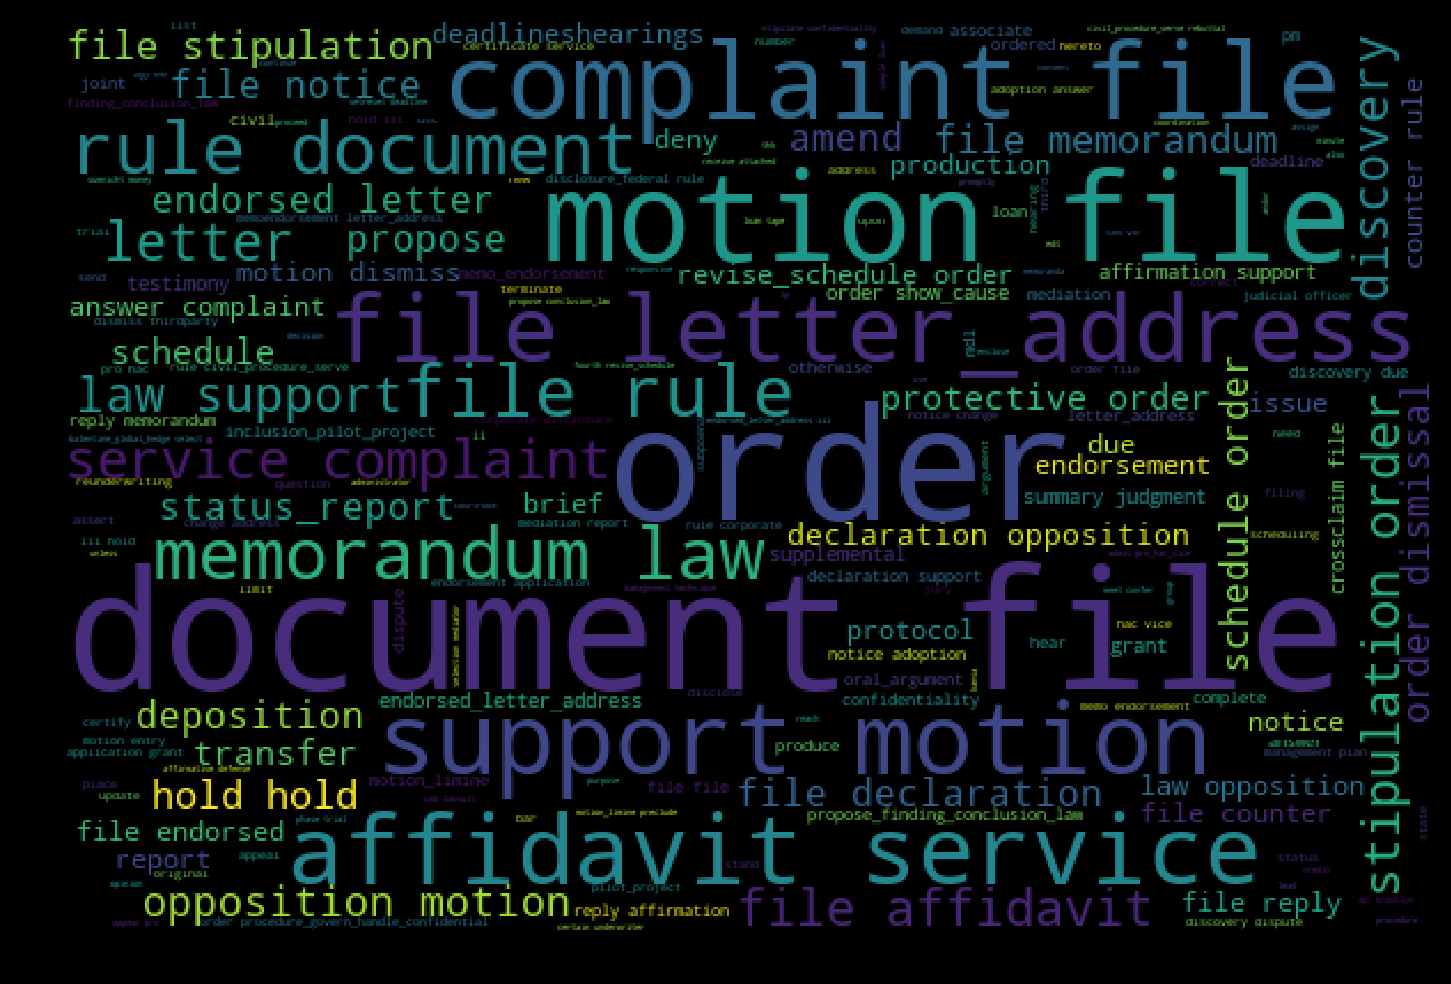

In [78]:
#Action Word cloud
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(action_wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

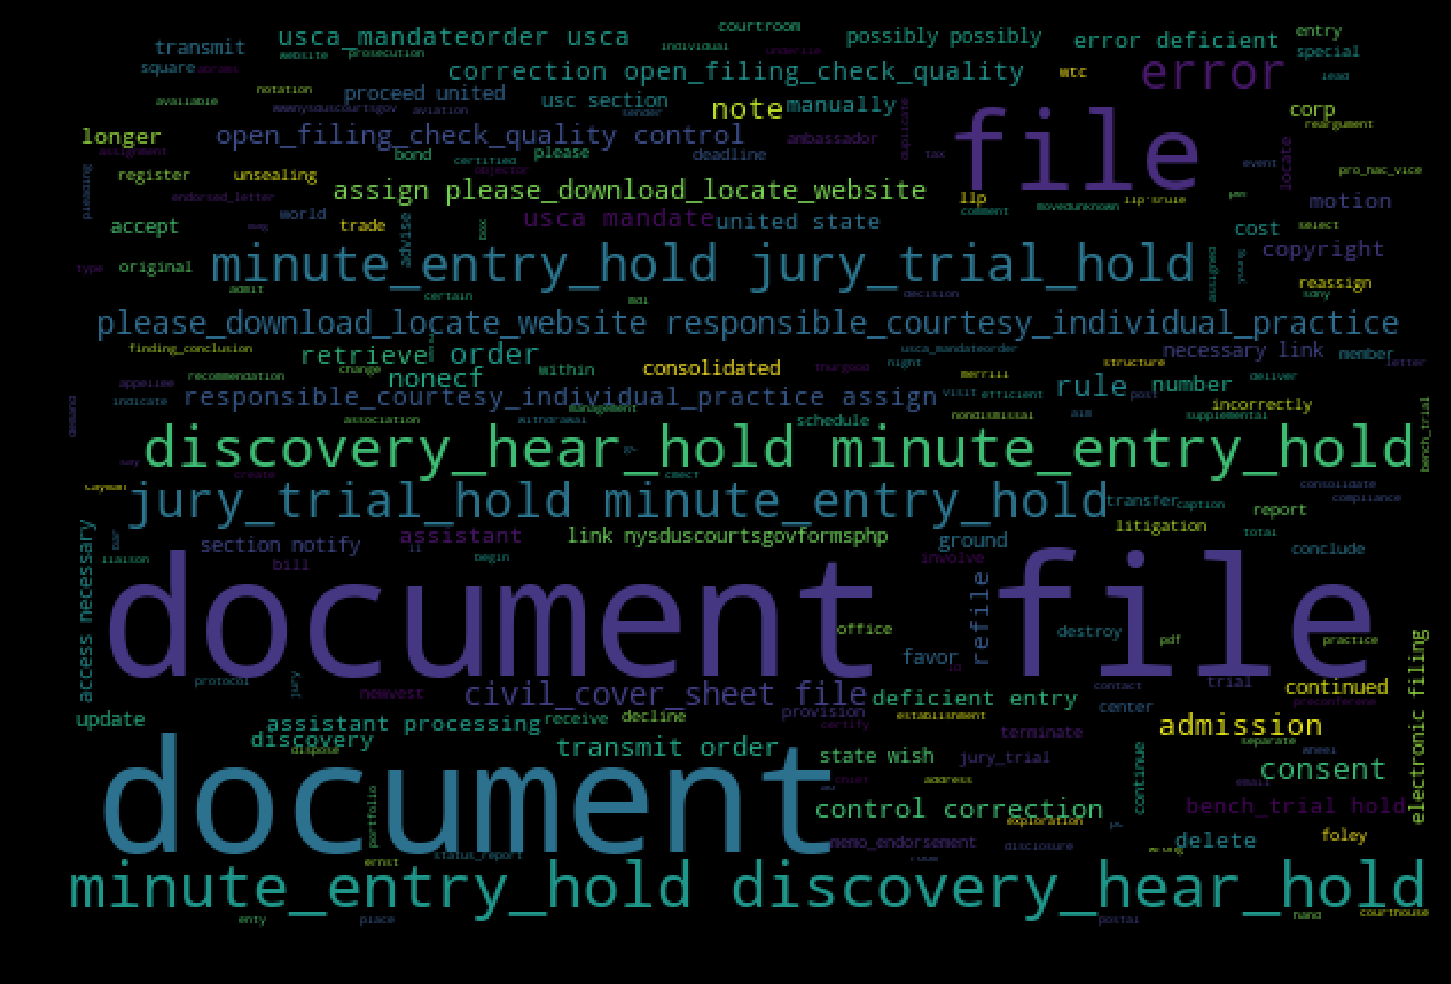

In [79]:
#No-Action Spam Word cloud
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(noaction_wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

### Machine Learning models - Default Hyperparameters

In [20]:
prediction = dict()
accuracy_scores = dict()

### Multinomial Naive Bayes

In [21]:
MNB_model = MultinomialNB()
MNB_model.fit(Xtrain_df, ytrain)
prediction['MNB'] = MNB_model.predict(Xtest_df)

In [22]:
accuracy_scores['MNB'] = accuracy_score(ytest, prediction['MNB'])
accuracy_scores['MNB']

0.848

### Logistic Regression

In [23]:
LR_model = LogisticRegression()
LR_model.fit(Xtrain_df, ytrain)
prediction['LR'] = LR_model.predict(Xtest_df)

In [24]:
accuracy_scores['LR'] = accuracy_score(ytest, prediction['LR'])
accuracy_scores['LR']

0.928

### KNN Classifier

In [25]:
KNN_model = KNeighborsClassifier(n_neighbors = 5)
KNN_model.fit(Xtrain_df, ytrain)
prediction['KNNC'] = KNN_model.predict(Xtest_df)

In [26]:
accuracy_scores['KNNC'] = accuracy_score(ytest, prediction['KNNC'])
accuracy_scores['KNNC']

0.8

### Ensemble Classifier: Random Forest

In [27]:
RFC_model = RandomForestClassifier()
RFC_model.fit(Xtrain_df, ytrain)
prediction['RFC'] = RFC_model.predict(Xtest_df)

In [28]:
accuracy_scores['RFC'] = accuracy_score(ytest, prediction['RFC'])
accuracy_scores['RFC']

0.928

### Ensemble Classifier: AdaBoost

In [29]:
ABC_model = AdaBoostClassifier()
ABC_model.fit(Xtrain_df, ytrain)
prediction['ABC'] = ABC_model.predict(Xtest_df)

In [30]:
accuracy_scores['ABC'] = accuracy_score(ytest, prediction['ABC'])
accuracy_scores['ABC']

0.92

In [31]:
accuracy_scores

{'ABC': 0.92, 'KNNC': 0.8, 'LR': 0.928, 'MNB': 0.848, 'RFC': 0.928}

### Parameter Tuning using GridSearchCV
Let's see how much we can improve each modeling algo...

#### MultinomialNB

In [52]:
def gridsearch(model, param_grid, cvs, X, y, plot = False):

    acc_by_cv = []
    print('selecting best cv parameter:')
    for cv in cvs:
        cloned_model = clone(model, safe = True)
        grid = GridSearchCV(cloned_model, param_grid = param_grid, n_jobs = 4, cv = cv)
        grid.fit(X, y)
        acc_by_cv.append(grid.best_score_)
        print(cv, ': ')
        print(grid.best_score_) #{'ABC': 0.92, 'KNNC': 0.8, 'LR': 0.928, 'MNB': 0.848, 'RFC': 0.944}
        print(grid.best_estimator_)
    
    best_cv = cvs[np.argmax(MNB_acc_by_cv)]
    print('\nbest cv: ', best_cv)
    
    grid = GridSearchCV(model, param_grid = param_grid, n_jobs = 4, cv = best_cv)
    grid.fit(Xtrain_df, ytrain)
    print(grid.best_score_) #{'ABC': 0.92, 'KNNC': 0.8, 'LR': 0.928, 'MNB': 0.848, 'RFC': 0.944}
    print(grid.best_estimator_)
    print(grid.grid_scores_)
    
    if plot:
        plt.plot(cvs, acc_by_cv)
        plt.show()
        
    return grid.best_estimator_, pd.DataFrame(MNB_grid.grid_scores_)

selecting best cv parameter:
2 : 
0.8697394789579158
MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)
3 : 
0.8817635270541082
MultinomialNB(alpha=0.8, class_prior=None, fit_prior=False)
4 : 
0.8797595190380761
MultinomialNB(alpha=0.7, class_prior=None, fit_prior=False)
5 : 
0.8817635270541082
MultinomialNB(alpha=0.8, class_prior=None, fit_prior=False)
6 : 
0.8837675350701403
MultinomialNB(alpha=0.9, class_prior=None, fit_prior=False)
7 : 
0.8837675350701403
MultinomialNB(alpha=0.9, class_prior=None, fit_prior=False)
8 : 
0.8837675350701403
MultinomialNB(alpha=0.9, class_prior=None, fit_prior=False)
9 : 
0.8797595190380761
MultinomialNB(alpha=0.7, class_prior=None, fit_prior=False)
10 : 
0.8777555110220441
MultinomialNB(alpha=0.9, class_prior=None, fit_prior=False)
11 : 
0.8857715430861723
MultinomialNB(alpha=1, class_prior=None, fit_prior=False)
12 : 
0.8877755511022044
MultinomialNB(alpha=1.1, class_prior=None, fit_prior=False)
13 : 
0.8857715430861723
MultinomialNB(alpha=1

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


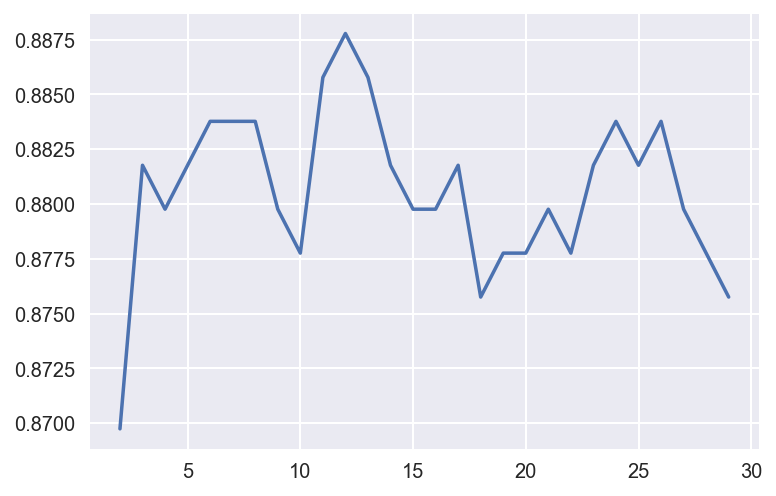

Wall time: 2min 2s


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [53]:
%%time
cvs = range(2, 30)
param_grid = {'fit_prior': [True, False], 
              'alpha': [0.01, 0.06, 0.07, 0.075, 0.08, 0.09, 0.1, 0.11, 0.12, 0.2, 0.5, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3,
                        1.4, 1.5, 1.6, 1.7, 2, 2.1, 2.15, 2.2, 2.25, 2.3, 2.4, 2.5, 2.6, 3, 5, 10]}

model = MultinomialNB()
optimized_MNB, MNB_results_df = gridsearch(model, param_grid, cvs, Xtrain_df, ytrain, plot = True)

In [39]:
param_grid = {'fit_prior': [True, False], 
              'alpha': [0.01, 0.06, 0.07, 0.075, 0.08, 0.09, 0.1, 0.11, 0.12, 0.2, 0.9, 1, 1.1, 1.2, 1.4, 1.5, 1.6, 1.7, 
               2, 2.1, 2.15, 2.2, 2.25, 2.3, 2.4, 2.5, 2.6, 3, 5, 10]}

MNB_acc_by_cv = []

for cv in cvs:
    MNB_model = MultinomialNB()
    MNB_grid = GridSearchCV(MNB_model, param_grid = param_grid, n_jobs = 4, cv = cv)
    MNB_grid.fit(Xtrain_df, ytrain)
    MNB_acc_by_cv.append(MNB_grid.best_score_)
    print(cv, ': ')
    print(MNB_grid.best_score_) #{'ABC': 0.92, 'KNNC': 0.8, 'LR': 0.928, 'MNB': 0.848, 'RFC': 0.944}
    print(MNB_grid.best_estimator_)

2 : 
0.8657314629258517
MultinomialNB(alpha=1.2, class_prior=None, fit_prior=False)
3 : 
0.8617234468937875
MultinomialNB(alpha=1.4, class_prior=None, fit_prior=False)
4 : 
0.8677354709418837
MultinomialNB(alpha=0.9, class_prior=None, fit_prior=False)
5 : 
0.8817635270541082
MultinomialNB(alpha=0.9, class_prior=None, fit_prior=False)
6 : 
0.8837675350701403
MultinomialNB(alpha=0.9, class_prior=None, fit_prior=False)
7 : 
0.8837675350701403
MultinomialNB(alpha=0.9, class_prior=None, fit_prior=False)
8 : 
0.8837675350701403
MultinomialNB(alpha=0.9, class_prior=None, fit_prior=False)
9 : 
0.8797595190380761
MultinomialNB(alpha=1, class_prior=None, fit_prior=False)
10 : 
0.8777555110220441
MultinomialNB(alpha=0.9, class_prior=None, fit_prior=False)
11 : 
0.8857715430861723
MultinomialNB(alpha=1, class_prior=None, fit_prior=False)


Exception ignored in: <bound method _ConnectionBase.__del__ of <multiprocessing.connection.PipeConnection object at 0x0000027A801ABF98>>
Traceback (most recent call last):
  File "c:\users\inves\appdata\local\programs\python\python35\lib\multiprocessing\connection.py", line 131, in __del__
    if self._handle is not None:
KeyboardInterrupt


12 : 
0.8877755511022044
MultinomialNB(alpha=1.1, class_prior=None, fit_prior=False)
13 : 
0.8857715430861723
MultinomialNB(alpha=1.1, class_prior=None, fit_prior=False)
14 : 
0.8817635270541082
MultinomialNB(alpha=1.1, class_prior=None, fit_prior=False)


KeyboardInterrupt: 

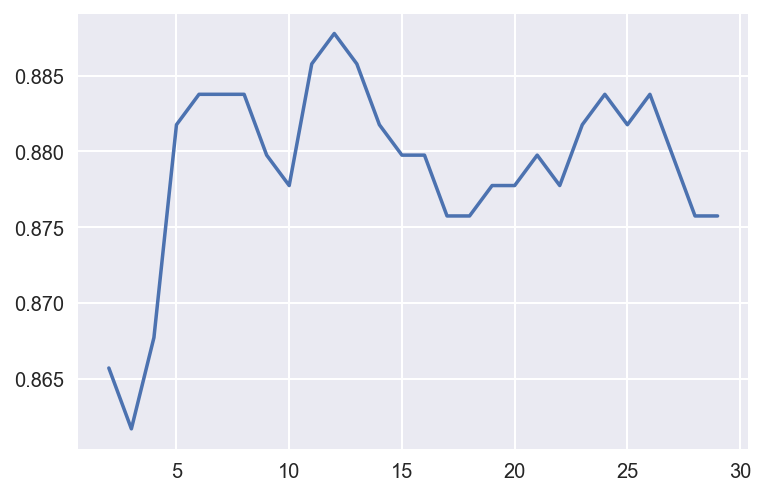

In [35]:

#seems like the best cv is 12, accuracy: 0.8877755511022044

In [50]:
MNB_model = MultinomialNB()
MNB_grid = GridSearchCV(MNB_model, param_grid = param_grid, n_jobs = 4, cv = cvs[np.argmax(MNB_acc_by_cv)])
MNB_grid.fit(Xtrain_df, ytrain)
print(MNB_grid.best_score_) #{'ABC': 0.92, 'KNNC': 0.8, 'LR': 0.928, 'MNB': 0.848, 'RFC': 0.944}
print(MNB_grid.best_estimator_)


0.8877755511022044
MultinomialNB(alpha=1.1, class_prior=None, fit_prior=False)


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,parameters,mean_validation_score,cv_validation_scores
0,"{'alpha': 0.01, 'fit_prior': True}",0.795591,"[0.7857142857142857, 0.9285714285714286, 0.833..."
1,"{'alpha': 0.01, 'fit_prior': False}",0.825651,"[0.8095238095238095, 0.8571428571428571, 0.952..."
2,"{'alpha': 0.06, 'fit_prior': True}",0.811623,"[0.7619047619047619, 0.9047619047619048, 0.809..."
3,"{'alpha': 0.06, 'fit_prior': False}",0.817635,"[0.7380952380952381, 0.8333333333333334, 0.904..."
4,"{'alpha': 0.07, 'fit_prior': True}",0.819639,"[0.8095238095238095, 0.9047619047619048, 0.785..."
5,"{'alpha': 0.07, 'fit_prior': False}",0.817635,"[0.7380952380952381, 0.8333333333333334, 0.904..."
6,"{'alpha': 0.075, 'fit_prior': True}",0.819639,"[0.8095238095238095, 0.9047619047619048, 0.785..."
7,"{'alpha': 0.075, 'fit_prior': False}",0.817635,"[0.7380952380952381, 0.8333333333333334, 0.904..."
8,"{'alpha': 0.08, 'fit_prior': True}",0.821643,"[0.8095238095238095, 0.9047619047619048, 0.785..."
9,"{'alpha': 0.08, 'fit_prior': False}",0.815631,"[0.7380952380952381, 0.8333333333333334, 0.904..."


In [51]:
MNB_grid.grid_scores_

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.79559, std: 0.06027, params: {'alpha': 0.01, 'fit_prior': True},
 mean: 0.82565, std: 0.05110, params: {'alpha': 0.01, 'fit_prior': False},
 mean: 0.81162, std: 0.05509, params: {'alpha': 0.06, 'fit_prior': True},
 mean: 0.81764, std: 0.04604, params: {'alpha': 0.06, 'fit_prior': False},
 mean: 0.81964, std: 0.05900, params: {'alpha': 0.07, 'fit_prior': True},
 mean: 0.81764, std: 0.04604, params: {'alpha': 0.07, 'fit_prior': False},
 mean: 0.81964, std: 0.05900, params: {'alpha': 0.075, 'fit_prior': True},
 mean: 0.81764, std: 0.04604, params: {'alpha': 0.075, 'fit_prior': False},
 mean: 0.82164, std: 0.05888, params: {'alpha': 0.08, 'fit_prior': True},
 mean: 0.81563, std: 0.04602, params: {'alpha': 0.08, 'fit_prior': False},
 mean: 0.81964, std: 0.06002, params: {'alpha': 0.09, 'fit_prior': True},
 mean: 0.81563, std: 0.05027, params: {'alpha': 0.09, 'fit_prior': False},
 mean: 0.81964, std: 0.06002, params: {'alpha': 0.1, 'fit_prior': True},
 mean: 0.81964, std: 0.05044, p

#### Logistic Regression

In [38]:
param_grid = {'solver': ['liblinear'],
              'penalty': ['l1', 'l2']}

LR_acc_by_cv = []

for cv in cvs:
    LR_model = LogisticRegression()
    LR_grid = GridSearchCV(LR_model, param_grid = param_grid, n_jobs = 4, cv = cv)
    LR_grid.fit(Xtrain_df, ytrain)
    LR_acc_by_cv.append(LR_grid.best_score_)
    print(cv, ': ')
    print(LR_grid.best_score_) #{'ABC': 0.92, 'KNNC': 0.8, 'LR': 0.928, 'MNB': 0.848, 'RFC': 0.944}
    print(LR_grid.best_estimator_)

2 : 
0.9238476953907816
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
3 : 
0.9238476953907816
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
4 : 
0.9318637274549099
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
5 : 
0.9298597194388778
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, m

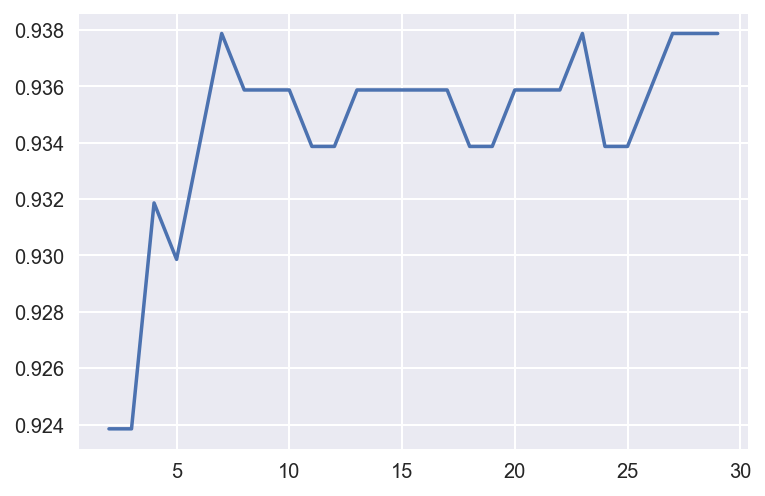

5

In [41]:
plt.plot(cvs, LR_acc_by_cv)
plt.show()
#seems like the best cv is 12, accuracy: 0.8877755511022044
np.argmax(LR_acc_by_cv)

In [42]:
LR_model = LogisticRegression()
LR_grid = GridSearchCV(LR_model, param_grid = param_grid, n_jobs = 4, cv = cvs[np.argmax(LR_acc_by_cv)])
LR_grid.fit(Xtrain_df, ytrain)
print(LR_grid.best_score_) #{'ABC': 0.92, 'KNNC': 0.8, 'LR': 0.928, 'MNB': 0.848, 'RFC': 0.944}
print(LR_grid.best_estimator_)
LR_grid.grid_scores_

0.9378757515030061
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.91583, std: 0.03018, params: {'penalty': 'l1', 'solver': 'liblinear'},
 mean: 0.93788, std: 0.03211, params: {'solver': 'liblinear', 'penalty': 'l2'}]

#### KNN Classifier

In [ ]:
param_grid = {'solver': ['liblinear'],
              'penalty': ['l1', 'l2']}

KNNC_model = KNeighborsClassifier()
grid_model = GridSearchCV(KNNC_model, param_grid = param_grid)
grid_model.fit(Xtrain_df, ytrain)


param_grid = {'solver': ['liblinear'],
              'penalty': ['l1', 'l2']}

LR_acc_by_cv = []

for cv in cvs:
    KNN_model = KNeighborsClassifier()
    KNN_grid = GridSearchCV(KNN_model, param_grid = param_grid, n_jobs = 4, cv = cv)
    KNN_grid.fit(Xtrain_df, ytrain)
    KNN_acc_by_cv.append(KNN_grid.best_score_)
    print(cv, ': ')
    print(KNN_grid.best_score_) #{'ABC': 0.92, 'KNNC': 0.8, 'LR': 0.928, 'MNB': 0.848, 'RFC': 0.944}
    print(KNN_grid.best_estimator_)

In [ ]:
print(grid_model.best_score_) #{'ABC': 0.92, 'KNNC': 0.8, 'LR': 0.928, 'MNB': 0.848, 'RFC': 0.944}
print(grid_model.best_estimator_)

In [ ]:
grid_model.grid_scores_

Random Forest

In [152]:
param_grid = {'n_estimators': [1, 10, 100, 1000]}

RFC_model = RandomForestClassifier(n_jobs = 4)
grid_model = GridSearchCV(RFC_model, param_grid = param_grid)
grid_model.fit(Xtrain_df, ytrain)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [153]:
print(grid_model.best_score_) #{'ABC': 0.92, 'KNNC': 0.8, 'LR': 0.928, 'MNB': 0.848, 'RFC': 0.944}
print(grid_model.best_estimator_)

0.9278557114228457
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [154]:
grid_model.grid_scores_

[mean: 0.86774, std: 0.01764, params: {'n_estimators': 1},
 mean: 0.92786, std: 0.01787, params: {'n_estimators': 10},
 mean: 0.91984, std: 0.01997, params: {'n_estimators': 100},
 mean: 0.91984, std: 0.02060, params: {'n_estimators': 1000}]

AdaBoost

In [ ]:
param_grid = {'solver': ['liblinear'],
              'penalty': ['l1', 'l2']}

ABC_model = AdaBoostClassifier()
grid_model = GridSearchCV(ABC_model, param_grid = param_grid)
grid_model.fit(Xtrain_df, ytrain)

In [ ]:
print(grid_model.best_score_) #{'ABC': 0.92, 'KNNC': 0.8, 'LR': 0.928, 'MNB': 0.848, 'RFC': 0.944}
print(grid_model.best_estimator_)

In [ ]:
grid_model.grid_scores_

In [ ]:
prediction_GS = dict()
accuracy_scores = dict()

In [ ]:
MNB = MultinomialNB()
MNB.fit(X_train_df, y_train)
prediction['MNB'] = MNB.predict(X_test_df)

MNB_treated = MultinomialNB()
MNB_treated.fit(X_train_treated_df, y_train)
prediction['MNB treated'] = MNB_treated.predict(X_test_treated_df)

accuracy_scores['MNB'] = accuracy_score(y_test, prediction['MNB'])
accuracy_scores['MNB treated'] = accuracy_score(y_test, prediction['MNB treated'])

{'alpha': [0.01, 0.1, 1, 10]}


In [109]:
KNC = KNeighborsClassifier()
grid = GridSearchCV(KNC, param_grid)
grid.fit(X_train_df, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(1, 30)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [110]:
grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [111]:
grid.best_params_

{'n_neighbors': 1}

In [112]:
grid.best_score_

0.9461521202602647

In [113]:
grid.grid_scores_

[mean: 0.94615, std: 0.00449, params: {'n_neighbors': 1},
 mean: 0.92259, std: 0.00288, params: {'n_neighbors': 2},
 mean: 0.92349, std: 0.00226, params: {'n_neighbors': 3},
 mean: 0.90554, std: 0.00117, params: {'n_neighbors': 4},
 mean: 0.90621, std: 0.00065, params: {'n_neighbors': 5},
 mean: 0.89410, std: 0.00060, params: {'n_neighbors': 6},
 mean: 0.89455, std: 0.00062, params: {'n_neighbors': 7},
 mean: 0.88580, std: 0.00141, params: {'n_neighbors': 8},
 mean: 0.88602, std: 0.00142, params: {'n_neighbors': 9},
 mean: 0.88198, std: 0.00262, params: {'n_neighbors': 10},
 mean: 0.88198, std: 0.00262, params: {'n_neighbors': 11},
 mean: 0.87660, std: 0.00210, params: {'n_neighbors': 12},
 mean: 0.87705, std: 0.00230, params: {'n_neighbors': 13},
 mean: 0.87256, std: 0.00223, params: {'n_neighbors': 14},
 mean: 0.87278, std: 0.00253, params: {'n_neighbors': 15},
 mean: 0.87009, std: 0.00051, params: {'n_neighbors': 16},
 mean: 0.87009, std: 0.00051, params: {'n_neighbors': 17},
 mean:

### Model Evaluation

In [114]:
print(classification_report(y_test, prediction['Multinomial'], target_names = ['Ham', 'Spam']))

             precision    recall  f1-score   support

        Ham       0.99      0.99      0.99       965
       Spam       0.97      0.95      0.96       150

avg / total       0.99      0.99      0.99      1115



In [115]:
conf_mat = confusion_matrix(y_test, prediction['Multinomial'])
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis = 1)[:, np.newaxis]

Text(0.5,16,'Predicted label')

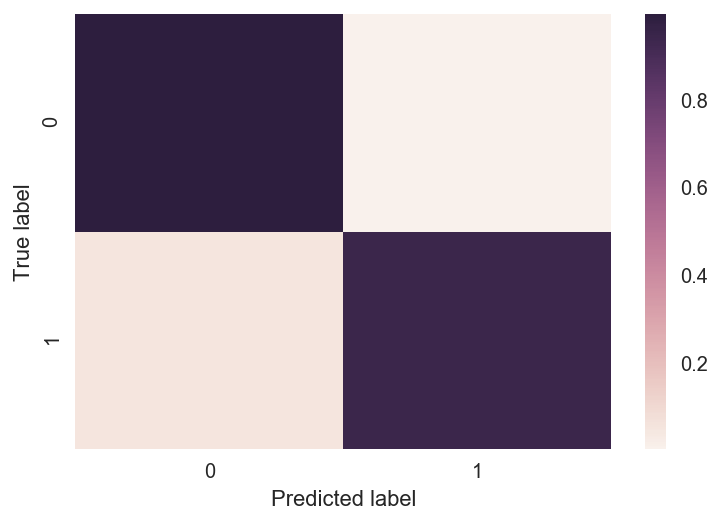

In [116]:
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Future works

In [117]:
print(conf_mat)

[[960   5]
 [  8 142]]


In [118]:
pd.set_option('display.max_colwidth', -1)

#### Misclassified as Spam

In [122]:
X_test[y_test < prediction['Multinomial']]

573     Waiting for your call.                                                                                                      
4727    I (Career Tel) have added u as a contact on INDYAROCKS.COM to send FREE SMS. To remove from phonebook - sms NO to  &lt;#&gt;
5475    Dhoni have luck to win some big title.so we will win:)                                                                      
4860    Nokia phone is lovly..                                                                                                      
1259    We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us                           
Name: text, dtype: object

#### Misclassfied as Ham

In [120]:
X_test[y_test > prediction['Multinomial']]

5035    You won't believe it but it's true. It's Incredible Txts! Reply G now to learn truly amazing things that will blow your mind. From O2FWD only 18p/txt       
2574    Your next amazing xxx PICSFREE1 video will be sent to you enjoy! If one vid is not enough for 2day text back the keyword PICSFREE1 to get the next video.   
3130    LookAtMe!: Thanks for your purchase of a video clip from LookAtMe!, you've been charged 35p. Think you can do better? Why not send a video in a MMSto 32323.
68      Did you hear about the new \Divorce Barbie\"? It comes with all of Ken's stuff!"                                                                            
2662    Hello darling how are you today? I would love to have a chat, why dont you tell me what you look like and what you are in to sexy?                          
4211    Missed call alert. These numbers called but left no message. 07008009200                                                                                    
3572    Yo